In [13]:
# unicode, regex, json for text digestion
import unicodedata
import re
import json

# nltk: natural language toolkit -> tokenization, stopwords
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

# pandas dataframe manipulation, acquire script, time formatting
import pandas as pd
from time import strftime

# shh, down in front
import warnings
warnings.filterwarnings('ignore')

from requests import get
from bs4 import BeautifulSoup
import os
import matplotlib.pyplot as plt

In [7]:
url = 'https://codeup.com/blog/'
headers = {'User-Agent': 'Codeup Data Science'}
response = get(url, headers=headers)

In [8]:
soup = BeautifulSoup(response.content, 'html.parser')

In [59]:
#1.
import re
import unicodedata
import pandas as pd
import nltk

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [60]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [61]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [62]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [63]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [64]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [65]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [66]:
word_counts.sort_values(by='all', ascending=False).head(10)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
4,287,168,119
dont,279,257,22
ok,277,272,5
free,275,59,216
know,267,241,26


In [67]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

,all,ham,spam
thats,94,94,0
i_,117,117,0
say,118,118,0
da,132,132,0
later,134,134,0
lor,160,160,0
awarded,38,0,38
18,43,0,43
guaranteed,50,0,50
tone,73,0,73


In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Proportion of Spam vs Ham for the 20 most common words')

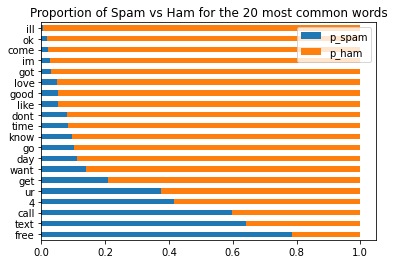

In [69]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')

In [70]:
(word_counts
 [(word_counts.spam > 10) & (word_counts.ham > 10)]
 .assign(ratio=lambda df: df.spam / (df.ham + .01))
 .sort_values(by='ratio')
 .pipe(lambda df: pd.concat([df.head(), df.tail()])))

,all,ham,spam,ratio
im,462,449,13,0.028953
good,235,223,12,0.053809
like,245,232,13,0.056032
need,182,171,11,0.064324
dont,279,257,22,0.085600
contact,70,14,56,3.997145
win,76,15,61,4.063957
cash,74,12,62,5.162365
mobile,150,15,135,8.994004
txt,163,13,150,11.529593


(-0.5, 399.5, 199.5, -0.5)

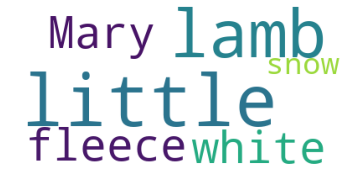

In [71]:
from wordcloud import WordCloud

sentence = 'Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow.'

img = WordCloud(background_color='white').generate(sentence)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

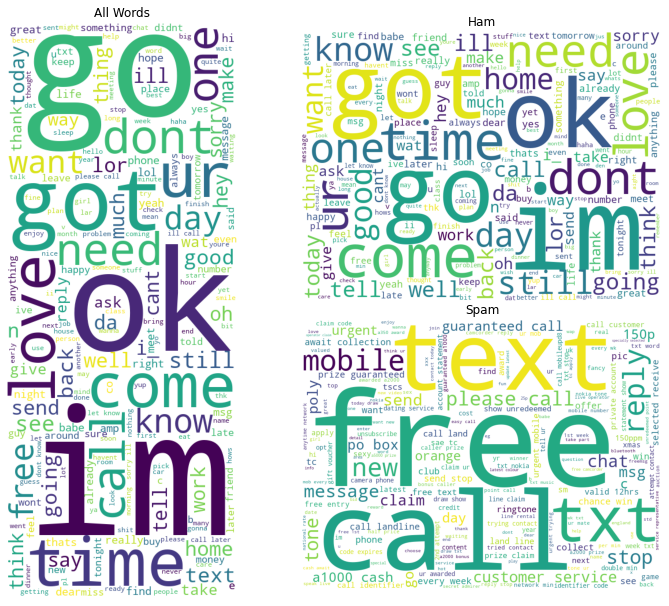

In [72]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

In [75]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

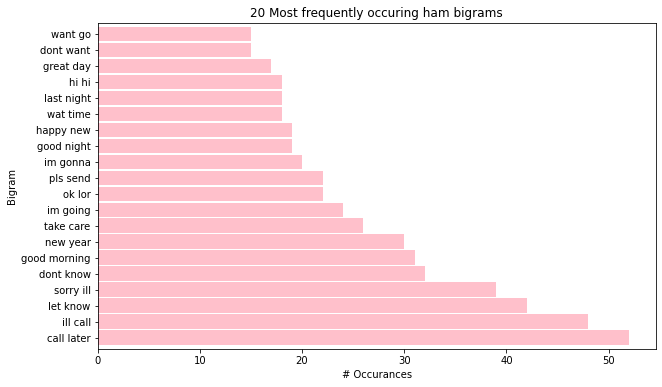

In [76]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

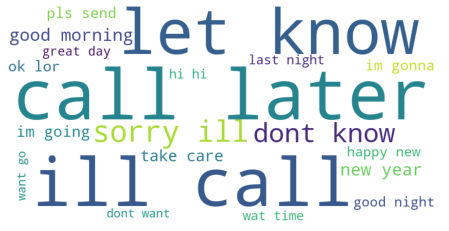

In [77]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [19]:
#2.
url = 'https://codeup.com/blog/'
headers = {'User-Agent': 'Codeup Data Science'}
response = get(url, headers=headers)

soup = BeautifulSoup(response.content, 'html.parser')

links = [link['href'] for link in soup.select('.more-link')]

articles = []

for url in links:
    
    url_response = get(url, headers=headers)
    soup = BeautifulSoup(url_response.text)
    
    title = soup.find('h1', class_='entry-title').text
    content = soup.find('div', class_='entry-content').text.strip()
    
    article_dict = {
        'title': title,
        'content': content
    }
    
    articles.append(article_dict)

In [20]:
codeup_df = pd.DataFrame(articles)
codeup_df

,title,content
0,Become a Data Scientist in 6 Months!,Are you feeling unfulfilled in your work but w...
1,Hiring Tech Talent Around the Holidays,Are you a hiring manager having trouble fillin...
2,Cloud Administration Program New Funding Options,Finding resources to fund your educational goa...
3,Why Dallas is a Great Location for IT Professi...,"When breaking into a new career, it is importa..."
4,Codeup is ranked #1 Best in DFW 2022,We are excited to announce that Codeup ranked ...
5,Codeup’s Scholarship Offerings,In honor of November being National Scholarshi...


In [9]:
#3.
categories = [li.text.lower() for li in soup.select('li')][1:]
categories[0] = 'national'

inshorts = []

for category in categories:
    
    url = 'https://inshorts.com/en/read' + '/' + category
    response = get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    titles = [span.text for span in soup.find_all('span', itemprop='headline')]
    contents = [div.text for div in soup.find_all('div', itemprop='articleBody')]
    
    for i in range(len(titles)):
        
        article = {
            'title': titles[i],
            'content': contents[i],
            'category': category,
        }
        
        inshorts.append(article)

In [10]:
news_df = pd.DataFrame(inshorts)
news_df

,title,content,category
0,Indian duo sets world record for fastest time ...,"Two Indian men, Dr Ali Irani and Sujoy Kumar M...",national
1,4 youths held for pelting stones on trains in ...,Four youths have been arrested for pelting sto...,national
2,"5 of family killed, 1 injured after car falls ...",Five persons of a family died and another pers...,national
3,"Cracks appear in some houses in UP's Aligarh, ...",After cracks developed in over 650 houses in U...,national
4,Delhi govt's failure on cleaning the Yamuna ri...,Delhi BJP Working President Virendra Sachdeva ...,national
5,"Disappearing Azad Party, says Cong's Ramesh on...",Congress leader Jairam Ramesh on Tuesday took ...,national
6,Did Pandavas kiss sister like Rahul kissed Pri...,"Dinesh Pratap Singh, a minister in the BJP-led...",national
7,SP spent over ₹25 crore during elections in UP...,The Samajwadi Party (SP) spent ₹25.76 crore fo...,national
8,His father caused 1984 genocide of Sikhs: SAD ...,While reacting to Congress leader Rahul Gandhi...,national
9,"Mufti criticises BJP, calls Jammu the worst vi...",PDP chief Mehbooba Mufti on Tuesday criticised...,national


In [50]:
bigrams = nltk.ngrams(news_df.content.str.split(), 2)
list(bigrams)

[(['Two',
   'Indian',
   'men,',
   'Dr',
   'Ali',
   'Irani',
   'and',
   'Sujoy',
   'Kumar',
   'Mitra,',
   'have',
   'set',
   'a',
   'new',
   'Guinness',
   'World',
   'Record',
   'for',
   'the',
   'fastest',
   'time',
   'to',
   'travel',
   'to',
   'all',
   'seven',
   'continents',
   'by',
   'accomplishing',
   'it',
   'in',
   'just',
   'three',
   'days,',
   'one',
   'hour',
   'and',
   'five',
   'minutes.',
   'The',
   'Guinness',
   'World',
   'Records',
   'said',
   'that',
   'the',
   'duo',
   'set',
   'the',
   'record',
   'in',
   'Melbourne,',
   'Australia',
   'on',
   'December',
   '7,',
   '2022.'],
  ['Four',
   'youths',
   'have',
   'been',
   'arrested',
   'for',
   'pelting',
   'stones',
   'at',
   'two',
   'trains',
   'in',
   'Uttar',
   "Pradesh's",
   'Mirzapur.',
   'As',
   'per',
   'reports,',
   'the',
   'accused',
   'allegedly',
   'pelted',
   'stones',
   'and',
   'damaged',
   'window',
   'panels',
   'of',

In [36]:
top_20_bigrams = (pd.Series(nltk.ngrams(words, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head()

(([Two, Indian, men,, Dr, Ali, Irani, and, Sujoy, Kumar, Mitra,, have, set, a, new, Guinness, World, Record, for, the, fastest, time, to, travel, to, all, seven, continents, by, accomplishing, it, in, just, three, days,, one, hour, and, five, minutes., The, Guinness, World, Records, said, that, the, duo, set, the, record, in, Melbourne,, Australia, on, December, 7,, 2022.], [Four, youths, have, been, arrested, for, pelting, stones, at, two, trains, in, Uttar, Pradesh's, Mirzapur., As, per, reports,, the, accused, allegedly, pelted, stones, and, damaged, window, panels, of, a, Rajdhani, Express, on, January, 8., According, to, police,, a, total, of, five, persons, were, booked, in, this, connection, on, the, basis, of, CCTV, footage.]), ([Four, youths, have, been, arrested, for, pelting, stones, at, two, trains, in, Uttar, Pradesh's, Mirzapur., As, per, reports,, the, accused, allegedly, pelted, stones, and, damaged, window, panels, of, a, Rajdhani, Express, on, January, 8., According, 

In [41]:
sentence = top_20_bigrams.head(1)

In [44]:
bigrams = nltk.ngrams(news_df.content.str.split(), 2)
list(bigrams)

[(['Two',
   'Indian',
   'men,',
   'Dr',
   'Ali',
   'Irani',
   'and',
   'Sujoy',
   'Kumar',
   'Mitra,',
   'have',
   'set',
   'a',
   'new',
   'Guinness',
   'World',
   'Record',
   'for',
   'the',
   'fastest',
   'time',
   'to',
   'travel',
   'to',
   'all',
   'seven',
   'continents',
   'by',
   'accomplishing',
   'it',
   'in',
   'just',
   'three',
   'days,',
   'one',
   'hour',
   'and',
   'five',
   'minutes.',
   'The',
   'Guinness',
   'World',
   'Records',
   'said',
   'that',
   'the',
   'duo',
   'set',
   'the',
   'record',
   'in',
   'Melbourne,',
   'Australia',
   'on',
   'December',
   '7,',
   '2022.'],
  ['Four',
   'youths',
   'have',
   'been',
   'arrested',
   'for',
   'pelting',
   'stones',
   'at',
   'two',
   'trains',
   'in',
   'Uttar',
   "Pradesh's",
   'Mirzapur.',
   'As',
   'per',
   'reports,',
   'the',
   'accused',
   'allegedly',
   'pelted',
   'stones',
   'and',
   'damaged',
   'window',
   'panels',
   'of',

In [48]:
top_20_bigrams = (pd.Series(nltk.ngrams(bigrams, 2))
                      .value_counts()
                      .head(20))

top_20_bigrams.head()

Series([], dtype: int64)

In [53]:
img = WordCloud(background_color='white').generate(ngrams)
plt.imshow(img)

NameError: name 'ngrams' is not defined